In [8]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Algo Trading - Backtesting
This notebook will be an introduction on how to research an algorthmic trading system.

Let's start by seeing how we can use yfinance to fetch equity data. Let's fetch the past twenty years of daily SPY pricing information (daily timeframe). If interested, you can change 'SPY' to some other ticker (AAPL, QQQ, etc.).

In [9]:
# fetch past 20 years of daily data for SPY
spy_df = yf.download('SPY', period='20y', interval='1d')
spy_df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-03-16,111.779999,112.059998,110.839996,111.790001,76.247749,59832600
2004-03-17,112.180000,113.260002,112.099998,113.040001,77.100311,41607300
2004-03-18,112.699997,113.269997,111.930000,113.070000,77.120773,60014300
2004-03-19,112.410004,112.570000,111.040001,111.059998,76.015373,48636200
2004-03-22,110.540001,110.570000,109.099998,109.650002,75.050262,62752100
...,...,...,...,...,...,...
2024-03-11,510.480011,511.880005,508.500000,511.279999,511.279999,62557200
2024-03-12,513.450012,517.380005,510.859985,516.780029,516.780029,73114400
2024-03-13,517.109985,517.289978,514.489990,515.969971,515.969971,55104100


We can see the outputted contents contain the Date as an index, Open, High, Low, Close, Adj Close, and Volume for each day. For this notebook's purposes, the Adj Close will be ignored. The next cell checks to see if there are any missing/nan values. There should not be. After, we can plot the close to see what it should look like.

In [10]:
# check to see if nan values exist
spy_df.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

<Axes: xlabel='Date'>

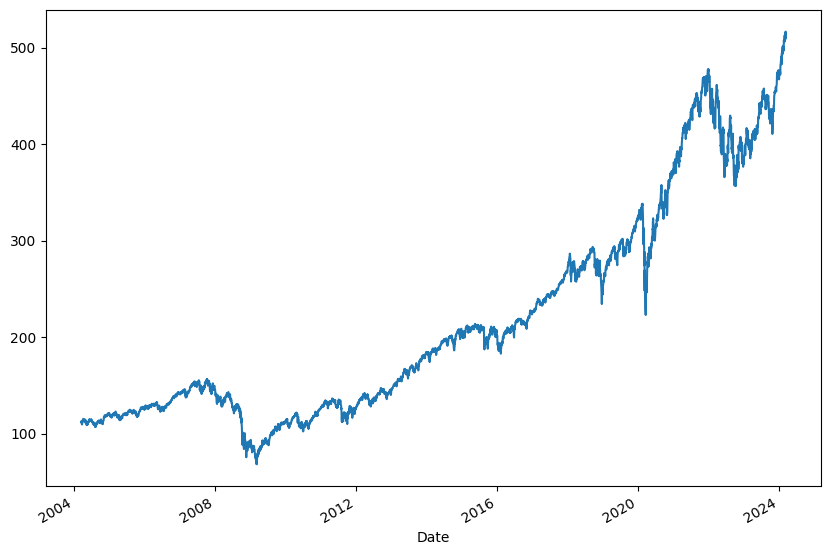

In [11]:
# plot the closing price.
spy_df['Close'].plot(figsize=(10, 7))

In [12]:
# notice how we can just use .plot(). This is because the yfinance function we used returns a pandas df:
type(spy_df)

pandas.core.frame.DataFrame

<Axes: >

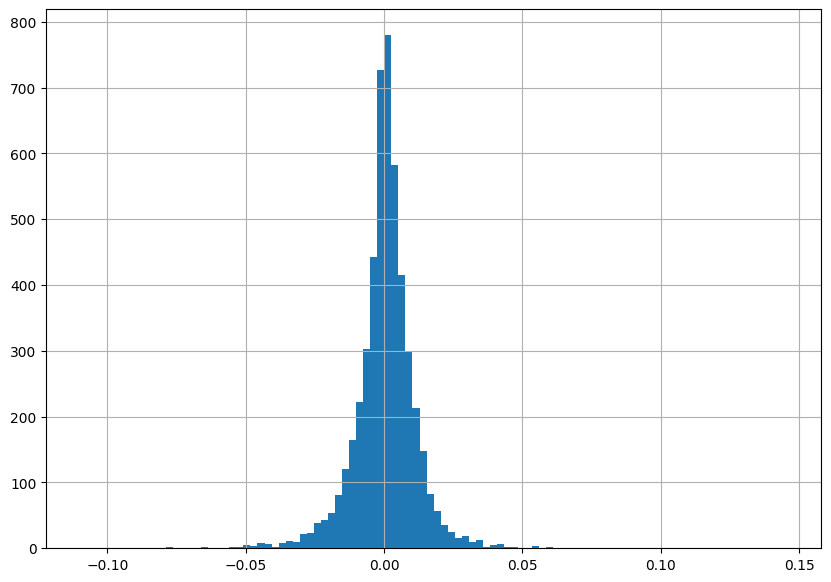

In [13]:
# let's add a new column for the daily returns (close to close pct change)
spy_df['daily_return'] = spy_df['Close'].pct_change()

# now output a histogram of the daily returns.
spy_df['daily_return'].hist(bins=100, figsize=(10, 7))



Notice anything familiar with this distribution? First lecture distributions 

Next we will implement a couple "baseline strategies", something to compare our algo trading system to. We will look at total return as well as the Sharpe Ratio. The Sharpe Ratio represents risk adjusted return. Generally, a Sharpe Ratio above 1 is considered good. Sometimes the Sharpe Ratio is calculated with the risk free rate (likely US Treasury Bonds). Another helpful matric is the Sortino Ratio. Similar to the Sharpe Ratio, but it only takes into account the variation in negative returns.

Something to always consider in trading is fees and other costs. Nowadays for something like SPY, the spread is almost always very small, maybe a penny or so. Many modern brokers provide no fee or zero commission trading. Another thing to consider is taxes. If the trading is done in a retirement account, it probably won't matter. However, issues with long term and short term capital gains tax may come into play. The additional gains made from a strategy that gets in and out of an equity on a daily basis may be offset by the higher short term capital gains whereas a buy and hold might only face long term capital gains tax when sold. 

In [14]:
# for the first baseline mode, it will be a simple buy and hold strategy.

# Assuming risk-free rate is 0
risk_free_rate = 0

# Calculate daily returns if not already calculated
spy_df['daily_return'] = spy_df['Close'].pct_change()

# Calculate cumulative return
buy_and_hold_ret = (spy_df['daily_return'] + 1).prod()

# Calculate the annualized return
annualized_return = ((1 + spy_df['daily_return'].mean()) ** 252) - 1

# Calculate the annualized volatility
annualized_volatility = spy_df['daily_return'].std() * np.sqrt(252)

# Calculate the annual Sharpe Ratio
sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility

# print results:
print("BASELINE 1: BUY AND HOLD")
print(f'Buy and hold return: {buy_and_hold_ret}')
print(f'Annualized return: {annualized_return}')
print(f'Sharpe ratio: {sharpe_ratio}')
print(f'Annualized volatility: {annualized_volatility}\n\n')

# for the second baseline model, we will buy the close and sell the open of the next day. 
# This strategy used to work pretty well a few decades ago, but doesn't work as well anymore.

# Calculate the overnight return
spy_df['overnight_return'] = (spy_df['Open'] - spy_df['Close'].shift(1)) / spy_df['Close'].shift(1)
total_return = (spy_df['overnight_return'] + 1).cumprod()
# annualize return and volatility to calculate sharpe ratio
annualized_return = ((1 + spy_df['overnight_return'].mean()) ** 252) - 1
annualized_volatility = spy_df['overnight_return'].std() * np.sqrt(252)
sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility

# print results:
print("BASELINE 2: OVERNIGHT RETURN")
print(f'Total return: {total_return[-1]}')
print(f'Annualized return: {annualized_return}')
print(f'Sharpe ratio: {sharpe_ratio}')
print(f'Annualized volatility: {annualized_volatility}')

BASELINE 1: BUY AND HOLD
Buy and hold return: 4.560604547785215
Annualized return: 0.0986625371421781
Sharpe ratio: 0.5183562466548999
Annualized volatility: 0.1903373168142093


BASELINE 2: OVERNIGHT RETURN
Total return: 2.7446506826359545
Annualized return: 0.0586393186497951
Sharpe ratio: 0.5181810870474193
Annualized volatility: 0.1131637570640029


/tmp/ipykernel_5308/2385774463.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Total return: {total_return[-1]}')


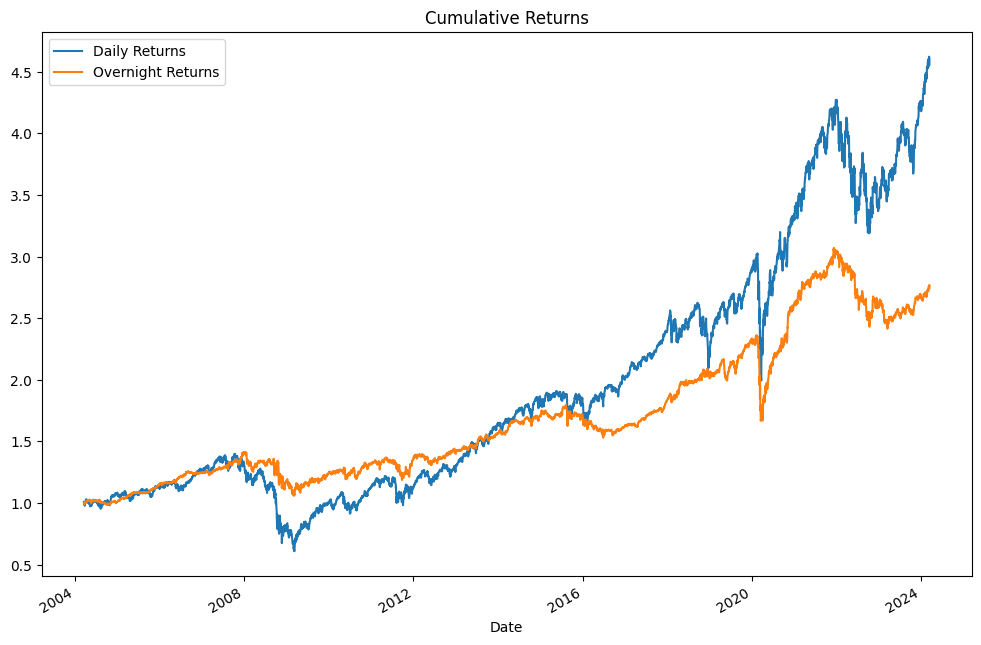

In [15]:
# We can plot the cumulative return of the overnight strategy vs the buy and hold strategy.
total_return = (spy_df['daily_return'] + 1).cumprod()
total_return2 = (spy_df['overnight_return'] + 1).cumprod()
# plot the results
total_return.plot(figsize=(12, 8), label='Daily Returns')
total_return2.plot(label='Overnight Returns')
plt.legend()
plt.title('Cumulative Returns')
plt.show()

### Custom Strategy
Before we get in further, we must address a crucial part of backtesting: splitting the data so we have a set we are not optimizing over to generate unrealistic results. This is a common and necessary data science practice. Another important thing to note is that in general, backtesting is not a research tool, but a validation tool.

In [16]:
DATA_SPLIT = 0.65
spy_df_train = spy_df.iloc[:int(len(spy_df) * DATA_SPLIT)]
spy_df_test = spy_df.iloc[int(len(spy_df) * DATA_SPLIT):]

Now let's consider the "golden cross" strategy. The idea is to buy when a short term moving average crosses above a long term moving average (signalling a change in trend) and to sell when it crosses below.

/tmp/ipykernel_5308/3843412200.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spy_df_train['fast_mavg'] = spy_df_train['Close'].rolling(window=fast_window, min_periods=fast_window, center=False).mean()
/tmp/ipykernel_5308/3843412200.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spy_df_train['slow_mavg'] = spy_df_train['Close'].rolling(window=slow_window, min_periods=slow_window, center=False).mean()
/tmp/ipykernel_5308/3843412200.py:11: SettingWithCopyWarning: 
A value is trying to be set on a co

Number of crossovers: 46
Number of crossunders: 45


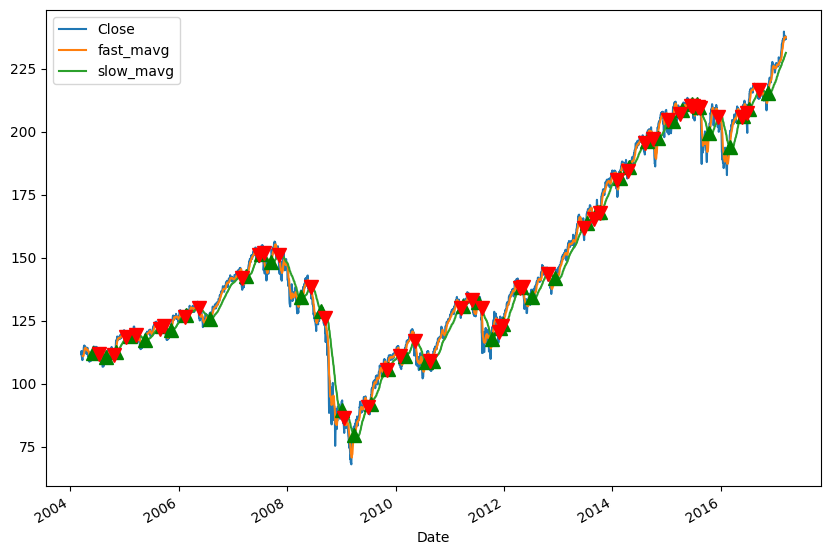

In [17]:
# Let's setup a few parameters that can be played around with. 

slow_window = 50
fast_window = 9

# Calculate the fast and slow moving averages
spy_df_train['fast_mavg'] = spy_df_train['Close'].rolling(window=fast_window, min_periods=fast_window, center=False).mean()
spy_df_train['slow_mavg'] = spy_df_train['Close'].rolling(window=slow_window, min_periods=slow_window, center=False).mean()

# Calculate crossover signal (fast greater than slow but not on previous bar)
spy_df_train['crossover_long'] = (spy_df_train['fast_mavg'] > spy_df_train['slow_mavg']) & (
    spy_df_train['fast_mavg'].shift(1) <= spy_df_train['slow_mavg'].shift(1))

# output how many times this happened
print(f"Number of crossovers: {spy_df_train['crossover_long'].sum()}")

# calculate crossunders
spy_df_train['crossover_short'] = (spy_df_train['fast_mavg'] < spy_df_train['slow_mavg']) & (
    spy_df_train['fast_mavg'].shift(1) >= spy_df_train['slow_mavg'].shift(1))

# output how many times this happened
print(f"Number of crossunders: {spy_df_train['crossover_short'].sum()}")

# create a chart of the close price, fast and slow moving averages, and the buy/sell signals
spy_df_train[['Close', 'fast_mavg', 'slow_mavg']].plot(figsize=(10, 7))
# plot the buy signals
plt.plot(spy_df_train.loc[spy_df_train.crossover_long].index,
         spy_df_train.fast_mavg[spy_df_train.crossover_long],
         '^', markersize=10, color='g')
# plot the sell signals
plt.plot(spy_df_train.loc[spy_df_train.crossover_short].index,
         spy_df_train.fast_mavg[spy_df_train.crossover_short],
         'v', markersize=10, color='r')
plt.show()

Play around with the slow and fast windows. Sometimes generating more signals result in lower quality ones. Also note we don't have too much data here, so not many signals may be generated.

In [18]:
# calculate returns information

# For now we will consider opening a long position on crossovers 
# and selling long positions on crossunders
# (meaning only longing, no shorting)

returns = []
current_entry_price = 0
# iterate over the dataframe rows and calculate returns
for index, row in spy_df_train.iterrows():
    if row['crossover_long']:
        current_entry_price = row['Close']
    elif row['crossover_short'] and current_entry_price != 0:
        returns.append((row['Close'] - current_entry_price) / current_entry_price)
        current_entry_price = 0

# calculate the average returns
average_returns = np.mean(returns)
# calculate the standard deviation of returns
std_returns = np.std(returns)

# calculate annualized return 

# print results
print(f"Cumulative returns: {np.prod([1+i for i in returns]) - 1}")
print(f"Number of profitable trades: {len([i for i in returns if i > 0])}")
print(f"Number of unprofitable trades: {len([i for i in returns if i < 0])}")
print(f"Number of trades: {len(returns)}")
print(f"Average return: {average_returns}")
print(f"Std return: {std_returns}")


Cumulative returns: 0.3084889034915643
Number of profitable trades: 18
Number of unprofitable trades: 27
Number of trades: 45
Average return: 0.00728660117222501
Std return: 0.051351198500528945


## Strategy Optimization
Now that we have a rough baseline for how this strategy works, let's do a grid search to see if we can find the best values for the windows and then check our hidden set to see if it holds.

In [19]:
def trial(df, long_window, short_window):
    '''given a df, long window length and short window length, return the cumulative returns'''
    # Calculate the fast and slow moving averages
    df['fast_mavg'] = df['Close'].rolling(window=short_window, min_periods=short_window, center=False).mean()
    df['slow_mavg'] = df['Close'].rolling(window=long_window, min_periods=long_window, center=False).mean()

    # Calculate crossover signal (fast greater than slow but not on previous bar)
    df['crossover_long'] = (df['fast_mavg'] > df['slow_mavg']) & (
        df['fast_mavg'].shift(1) <= df['slow_mavg'].shift(1))
    
    # calculate crossunders
    df['crossover_short'] = (df['fast_mavg'] < df['slow_mavg']) & (
        df['fast_mavg'].shift(1) >= df['slow_mavg'].shift(1))
    
    returns = []
    current_entry_price = 0
    # iterate over the dataframe rows and calculate returns
    for index, row in df.iterrows():
        if row['crossover_long']:
            current_entry_price = row['Close']
        elif row['crossover_short'] and current_entry_price != 0:
            returns.append((row['Close'] - current_entry_price) / current_entry_price)
            current_entry_price = 0

    # return cumulative returns
    return np.prod([1+i for i in returns]) - 1

for long_window in [20, 50, 100, 200, 500]:
    for short_window in [10, 20, 50]:
        print(f"long_window: {long_window}, short_window: {short_window}, returns: {trial(spy_df_train, long_window, short_window)}")


/tmp/ipykernel_5308/2209879970.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fast_mavg'] = df['Close'].rolling(window=short_window, min_periods=short_window, center=False).mean()
/tmp/ipykernel_5308/2209879970.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['slow_mavg'] = df['Close'].rolling(window=long_window, min_periods=long_window, center=False).mean()
/tmp/ipykernel_5308/2209879970.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

long_window: 20, short_window: 10, returns: 0.1687202803150305
long_window: 20, short_window: 20, returns: 0.0
long_window: 20, short_window: 50, returns: 0.4614745882429956
long_window: 50, short_window: 10, returns: 0.3426237634526177
long_window: 50, short_window: 20, returns: 0.3259224525149915
long_window: 50, short_window: 50, returns: 0.0
long_window: 100, short_window: 10, returns: 0.7930613058337055
long_window: 100, short_window: 20, returns: 0.6467771969368463
long_window: 100, short_window: 50, returns: 0.8520919546209307
long_window: 200, short_window: 10, returns: 0.8347487040265058
long_window: 200, short_window: 20, returns: 0.8396622349513594
long_window: 200, short_window: 50, returns: 0.8574072700142772
long_window: 500, short_window: 10, returns: 0.548395771720553
long_window: 500, short_window: 20, returns: 0.4022307117104553
long_window: 500, short_window: 50, returns: 0.5266037087994986


/tmp/ipykernel_5308/3961549199.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spy_df_test['fast_mavg'] = spy_df_test['Close'].rolling(window=short_window, min_periods=short_window, center=False).mean()
/tmp/ipykernel_5308/3961549199.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spy_df_test['slow_mavg'] = spy_df_test['Close'].rolling(window=long_window, min_periods=long_window, center=False).mean()
/tmp/ipykernel_5308/3961549199.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy 

Cumulative return: 1.3714582698001787


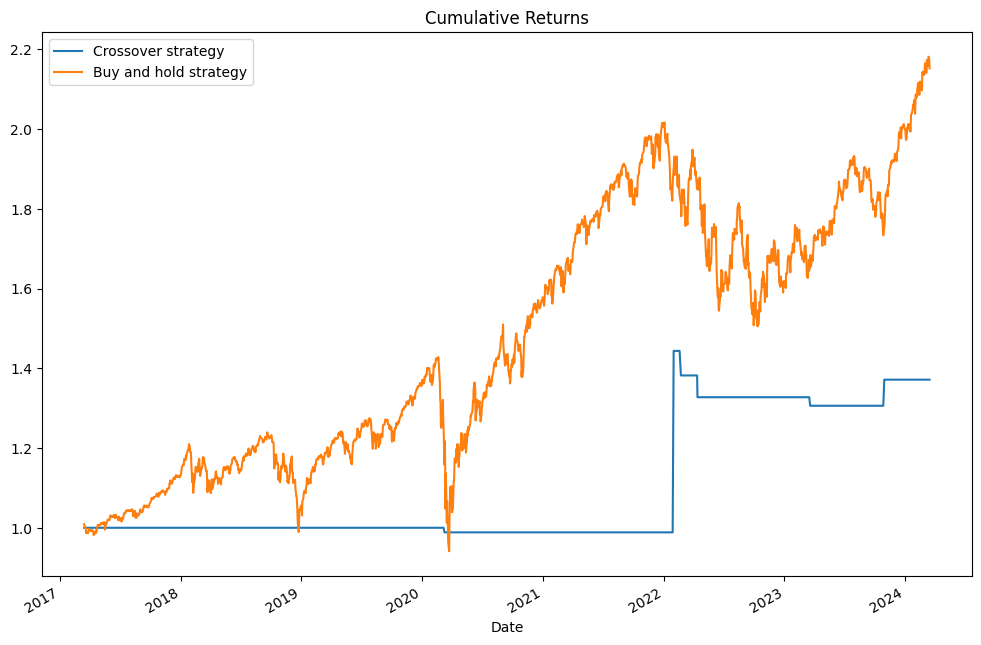

In [20]:
# confirm results with test set to see if the performance is still good

long_window = 200
short_window = 10
spy_df_test['fast_mavg'] = spy_df_test['Close'].rolling(window=short_window, min_periods=short_window, center=False).mean()
spy_df_test['slow_mavg'] = spy_df_test['Close'].rolling(window=long_window, min_periods=long_window, center=False).mean()

# Calculate crossover signal (fast greater than slow but not on previous bar)
spy_df_test['crossover_long'] = (spy_df_test['fast_mavg'] > spy_df_test['slow_mavg']) & (
    spy_df_test['fast_mavg'].shift(1) <= spy_df_test['slow_mavg'].shift(1))

# calculate crossunders
spy_df_test['crossover_short'] = (spy_df_test['fast_mavg'] < spy_df_test['slow_mavg']) & (
    spy_df_test['fast_mavg'].shift(1) >= spy_df_test['slow_mavg'].shift(1))

# add a new column for return that's 0 by default, and the relevant return if a buy or sell signal is present
current_entry_price = 0
spy_df_test['return'] = 0

# iterate over the dataframe rows and calculate returns
for index, row in spy_df_test.iterrows():
    if row['crossover_long']:
        current_entry_price = row['Close']
    elif row['crossover_short'] and current_entry_price != 0:
        spy_df_test.loc[index, 'return'] = (row['Close'] - current_entry_price) / current_entry_price
        current_entry_price = 0

# calculate cumulative returns
cumulative_return = (spy_df_test['return'] + 1).cumprod()
print(f"Cumulative return: {cumulative_return[-1]}")

# plot cumulative returns for test set against buy and hold strategy for test set
total_return = (spy_df_test['daily_return'] + 1).cumprod()
cumulative_return.plot(figsize=(12, 8), label='Crossover strategy')
total_return.plot(label='Buy and hold strategy')
plt.legend()
plt.title('Cumulative Returns')
plt.show()


## Your Custom Strategy
Up until this point, you haven't been able to do much on your own with this file. Now you have the tools to implement your own strategy. Consider researching some technical analysis indicators (eg: MACD, RSI, Bollinger Bands, EMA, ADX) online to try and add to your strategy. Provided below is a barebones function similar to the above strategy. Feel free to completely change the structure. You could have it buy one day and sell in 10 days, close position if market moves too fast down, etc..

In [21]:
# I created below with ChatGPT since it was my first time. Then I worked to understand the results ChatGPT gave to learn from this exercise. 
def moving_average_crossover_strategy(df, short_window=50, long_window=200):
    # Create indicators
    df['Short_MA'] = df['Close'].rolling(window=short_window, min_periods=1).mean()
    df['Long_MA'] = df['Close'].rolling(window=long_window, min_periods=1).mean()

    # Create entry signal: When short MA crosses above long MA
    df['Entry_Signal'] = np.where(df['Short_MA'] > df['Long_MA'], 1, 0)
    
    # Create exit signal: When short MA crosses below long MA
    df['Exit_Signal'] = np.where(df['Short_MA'] < df['Long_MA'], 1, 0)
    
    # Calculate returns
    df['Position'] = df['Entry_Signal'] - df['Exit_Signal']
    df['Returns'] = df['Position'].shift(1) * df['Close'].pct_change()
    df['Cumulative_Returns'] = (1 + df['Returns']).cumprod()

    # Plotting (Optional)
    # ...

    # Return cumulative return or other relevant information
    return df['Cumulative_Returns'].iloc[-1]

# Example usage:
# Assuming df is a DataFrame with 'Date' and 'Close' columns containing historical price data
# result = moving_average_crossover_strategy(df)
# print("Final cumulative return:", result) 